In [1]:
import os,time,torch,glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Dropout,Flatten,LSTM,Activation

d:\Python\python\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
timeset=[0,0,0]
model_names=["CNN","LSTM","Transfer"]
accuracy_set=[]

def load_data():
    #導入資料
    print("-----loading data-----")
    path1='不會掉血壓名單'
    path2='會掉血壓名單'
    no=glob.glob(os.path.join(path1,'*.xls'))
    yes=glob.glob(os.path.join(path2,'*.xls'))
    global df1,df2
    df1=pd.concat((pd.read_excel(f) for f in no),ignore_index=True)
    df2=pd.concat((pd.read_excel(i) for i in yes),ignore_index=True)

def xls_to_array():
    #將會掉血壓資料編碼為1，不會掉血壓編碼為0，整理成矩陣，去掉多餘部分
    print("-----transfering xls to array-----")
    global df,feature,label
    df1['category'] = 0
    df2['category'] = 1
    df = pd.concat([df1,df2],ignore_index=True)
    df=df[['TOTAL_UF','BLOOD_FLOW','CONDUCTIVITY','VENOUS','TEMP','MAX_BLOOD','MIN_BLOOD','PULSE','category']]
    df=df.dropna()
    df=df.reset_index(drop=True)
    for i in ['TOTAL_UF','BLOOD_FLOW','CONDUCTIVITY','VENOUS','TEMP','MAX_BLOOD','MIN_BLOOD','PULSE']:
        data_error_index=[]
        for ii in range(df.shape[0]):
            data_col=df.iloc[ii][i]
            try:
                value=float(data_col)
            except:
                value='false'
            if str(value).find('false')>-1:
                data_error_index.append(ii)
        df.drop(index=data_error_index,inplace=True)
        df=df.reset_index(drop=True)
    feature=df[['TOTAL_UF','BLOOD_FLOW','CONDUCTIVITY','VENOUS','TEMP','MAX_BLOOD','MIN_BLOOD','PULSE']].values
    label=df['category'].values
    feature=np.array(feature)
    label=np.array(label)

def split_dataset():
    #切分資料集成訓練集和測試集
    print("-----spliting dataset-----")
    global x_train,x_test,y_train,y_test
    x_train,x_test,y_train,y_test = train_test_split(feature,label,train_size=0.8,shuffle=True,stratify=label)
    x_train=x_train.astype('float')
    x_test=x_test.astype('float')
    y_train=y_train.astype('float')
    y_test=y_test.astype('float')


def Accuracy(model_): 
    #準確率部分我已寫好，包括熱力圖、準確率、recall、F1-score等
    print("-----testing accuracy-----")
    model_pre=model_.predict(x_test,verbose=0)
    mean=0
    pred=model_pre.tolist()
    total=len(pred)
    for i in range(len(pred)):
        if 0.1<pred[i][0]<0.9:
            mean+=pred[i][0]
        else:
            total-=1
    mean=mean/total
    y_pred=[]
    for i in range(model_pre.shape[0]):
        if model_pre[i]>=mean:
            y_pred.append(1)
        else:
            y_pred.append(0)
    y_pred=np.array(y_pred)
    mat=confusion_matrix(y_test,y_pred)
    sns.set(font_scale=1)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    sns.heatmap(mat,square=True,annot=True,fmt='d',cbar=False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel("true label")
    plt.xlabel("predicted label")
    plt.show()
    target_names=['0','1']
    print(classification_report(y_test,y_pred,target_names=target_names))
    accuracy_set.append(model_.evaluate(x_test, y_test)[1])

def CNN_model_built():
    #建立CNN模型
    global CNN_model
    CNN_model=Sequential()
    CNN_model.add(Dense(units = 8, input_dim=8, activation = 'relu'))
    CNN_model.add(Dropout(0.1))
    CNN_model.add(Dense(units = 100 , activation = 'relu'))
    CNN_model.add(Dropout(0.1))
    CNN_model.add(Dense(units = 100 , activation = 'relu'))
    CNN_model.add(Dropout(0.1))
    CNN_model.add(Dense(units = 100 , activation = 'relu'))
    CNN_model.add(Dropout(0.1))
    CNN_model.add(Dense(units = 1 , activation = 'sigmoid'))
    CNN_model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    #添加層...
    #CNN_model.add(...)

def LSTM_model_built():
    #建立LSTM模型
    global LSTM_model,LSTM_layers
    LSTM_layers=[
        LSTM(units = 8, return_sequences = True,input_shape=(x_train.shape[1],1)),
        Dropout(0.1),
        LSTM(units = 50, return_sequences = True),
        Dropout(0.1),
        LSTM(units = 50, return_sequences = True),
        Dropout(0.1),
        LSTM(units = 50),
        Dropout(0.1)
    ]
    Output_layers=[
        Dense(units = 1),
        Activation('sigmoid')
    ]
    LSTM_model = Sequential(LSTM_layers + Output_layers)
    LSTM_model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

def Build_combined_model():
    #建立遷移學習模型
    global Transfer_model
    for layer in LSTM_layers:
        layer.trainable = False
    New_output_layers=[
        Dense(units = 20),
        Activation('relu'),
        Dropout(0.1),
        Dense(units = 1),
        Activation('sigmoid')
    ]
    Transfer_model = Sequential(LSTM_layers+New_output_layers)
    Transfer_model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

def Training_process(model_):
    #訓練模型
    print("-----training model-----")
    train_history=model_.fit(x=x_train,y=y_train,validation_split=0.2,epochs=20,batch_size=200,verbose=1)
    

def Model_detail(model_number):
    #模型信息對比
    print("----------")
    print()
    print("模型{}：".format(model_number+1),model_names[model_number])
    print()
    print("訓練時間：",round(timeset[model_number],2))
    print("準確率：",round(accuracy_set[model_number],4))
    print()

In [3]:
def Preprocess(): #預處理
    load_data()
    xls_to_array()
    split_dataset()

def CNN_training(): #全部模型-CNN模型
    print("-----training CNN model-----")
    CNN_model_built()
    Training_process(CNN_model)
    Accuracy(CNN_model)
    
def LSTM_training(): #全部模型-LSTM模型
    print("-----training LSTM model-----")
    LSTM_model_built()
    Training_process(LSTM_model)
    Accuracy(LSTM_model)

def LSTM_plus_transfer_training(): #全部模型-遷移學習模型
    print("-----training transfer learning model-----")
    Build_combined_model()
    Training_process(Transfer_model)
    Accuracy(Transfer_model)

def Model_training(): #全部模型的訓練
    print("-----training models-----")
    timeset[0]=time.time()
    CNN_training()
    timeset[0]=time.time()-timeset[0]
    timeset[1]=time.time()
    LSTM_training()
    timeset[1]=time.time()-timeset[1]
    timeset[2]=time.time()
    LSTM_plus_transfer_training()
    timeset[2]=time.time()-timeset[2]

def Compare(): #正確率比較
    print("-----comparing models-----")
    for model_number in range(3):
        Model_detail(model_number)

-----loading data-----
-----transfering xls to array-----
-----spliting dataset-----
-----training models-----
-----training CNN model-----
-----training model-----
Epoch 1/20
2668/2668 [==============================] - 8s 3ms/step - loss: 0.7852 - accuracy: 0.5476 - val_loss: 0.6784 - val_accuracy: 0.5694
Epoch 2/20
2668/2668 [==============================] - 7s 3ms/step - loss: 0.6860 - accuracy: 0.5703 - val_loss: 0.6817 - val_accuracy: 0.5768
Epoch 3/20
2668/2668 [==============================] - 7s 3ms/step - loss: 0.6798 - accuracy: 0.5763 - val_loss: 0.6757 - val_accuracy: 0.5709
Epoch 4/20
2668/2668 [==============================] - 7s 3ms/step - loss: 0.6809 - accuracy: 0.5833 - val_loss: 0.6656 - val_accuracy: 0.5923
Epoch 5/20
2668/2668 [==============================] - 7s 3ms/step - loss: 0.6706 - accuracy: 0.5890 - val_loss: 0.6580 - val_accuracy: 0.6084
Epoch 6/20
2668/2668 [==============================] - 7s 3ms/step - loss: 0.6654 - accuracy: 0.5976 - val_loss: 0

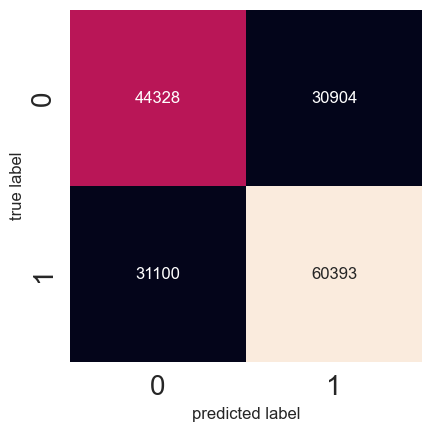

              precision    recall  f1-score   support

           0       0.59      0.59      0.59     75232
           1       0.66      0.66      0.66     91493

    accuracy                           0.63    166725
   macro avg       0.62      0.62      0.62    166725
weighted avg       0.63      0.63      0.63    166725

5211/5211 [==============================] - 5s 1ms/step - loss: 0.6372 - accuracy: 0.6430
-----training LSTM model-----
-----training model-----
Epoch 1/20
2668/2668 [==============================] - 70s 24ms/step - loss: 0.6842 - accuracy: 0.5549 - val_loss: 0.6745 - val_accuracy: 0.5625
Epoch 2/20
2668/2668 [==============================] - 76s 28ms/step - loss: 0.6726 - accuracy: 0.5726 - val_loss: 0.6649 - val_accuracy: 0.5825
Epoch 3/20
2668/2668 [==============================] - 74s 28ms/step - loss: 0.6642 - accuracy: 0.5886 - val_loss: 0.6523 - val_accuracy: 0.6120
Epoch 4/20
2668/2668 [==============================] - 77s 29ms/step - loss: 0.6514 - ac

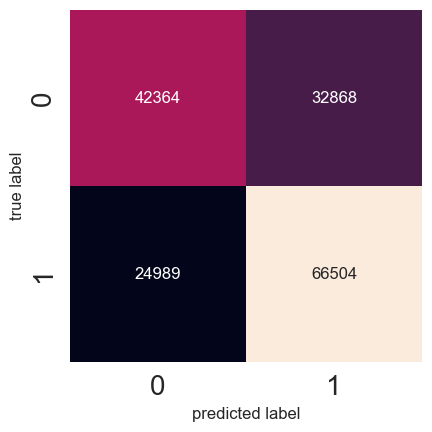

              precision    recall  f1-score   support

           0       0.63      0.56      0.59     75232
           1       0.67      0.73      0.70     91493

    accuracy                           0.65    166725
   macro avg       0.65      0.64      0.65    166725
weighted avg       0.65      0.65      0.65    166725

5211/5211 [==============================] - 33s 6ms/step - loss: 0.6700 - accuracy: 0.6569
-----training transfer learning model-----
-----training model-----
Epoch 1/20
2668/2668 [==============================] - 59s 19ms/step - loss: 0.4881 - accuracy: 0.7602 - val_loss: 0.6655 - val_accuracy: 0.6595
Epoch 2/20
2668/2668 [==============================] - 57s 21ms/step - loss: 0.4827 - accuracy: 0.7629 - val_loss: 0.6608 - val_accuracy: 0.6599
Epoch 3/20
2668/2668 [==============================] - 37s 14ms/step - loss: 0.4820 - accuracy: 0.7630 - val_loss: 0.6623 - val_accuracy: 0.6608
Epoch 4/20
2668/2668 [==============================] - 36s 13ms/step - los

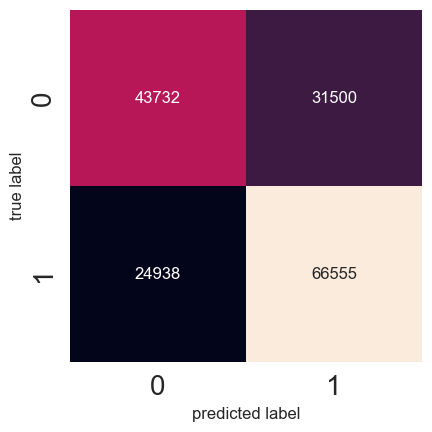

              precision    recall  f1-score   support

           0       0.64      0.58      0.61     75232
           1       0.68      0.73      0.70     91493

    accuracy                           0.66    166725
   macro avg       0.66      0.65      0.66    166725
weighted avg       0.66      0.66      0.66    166725

5211/5211 [==============================] - 21s 4ms/step - loss: 0.6625 - accuracy: 0.6626
-----comparing models-----
----------

模型1： CNN

訓練時間： 158.68
準確率： 0.643

----------

模型2： LSTM

訓練時間： 1604.08
準確率： 0.6569

----------

模型3： Transfer

訓練時間： 897.1
準確率： 0.6626



In [4]:
def main(): #主程序
    Preprocess() #預處理
    Model_training() #模型訓練
    Compare() #比較
main()